In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bootstrapped.bootstrap import bootstrap
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import bootstrapped.permutation as pm
from datetime import timedelta
import scipy.stats as stats
from scipy.stats import sem
import pandas as pd
import numpy as np
import swifter
import copy
import sys
import re
import os.path
import warnings
warnings.filterwarnings('ignore')

# Local Modules
#sys.path.insert(0, os.path.abspath('/data/manoel/platform_bans/'))
from helpers.vars import interventions, interventions_helper, int_ls, int_c, grace_period, exclude_dates
from helpers.regression_helpers import regression_helper, get_coms, get_content_helper
from helpers.plot import set_size, match_plot_ccdf, plot_intervention
from helpers.match_helpers import get_matched_dataframes

In [3]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.dates
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)
DATA_PATH = "./data_gc/"

## Loads data

In [4]:
df_before_after_in = pd.read_csv("./data/reproducibility_data/gc/user_matched_incels.csv")
df_before_after_td = pd.read_csv("./data/reproducibility_data/gc/user_matched_gc.csv")
df_before_after_in_f = pd.read_csv("./data/reproducibility_data/gc/user_matched_incels_f.csv")
df_before_after_td_f = pd.read_csv("./data/reproducibility_data/gc/user_matched_gc_f.csv")
df_gb_in = pd.read_csv("./data/reproducibility_data/gc/user_incels.csv")
df_gb_td = pd.read_csv("./data/reproducibility_data/gc/user_gc.csv")

## Figure 4

TD
mean all before 11.673523629214301    (10.951281584504478, 12.468293526541906)
mean matched before 69.24663677130044    (51.12085201793722, 95.74136771300446)
mean all after 42.04615384615384    (32.96269230769231, 59.42448717948717)
mean matched after 38.08071748878924    (27.829596412556054, 51.59674887892376)
Reddit all vs. matched
KstestResult(statistic=0.4787391439362943, pvalue=1.4971512479135505e-44)
Fringe all vs. matched
KstestResult(statistic=0.026213061975393814, pvalue=0.750604276131418)
Reddit all vs. Fringe all
KstestResult(statistic=0.2873813218020602, pvalue=6.32177274493559e-103)
Reddit matched vs. Fringe matched
KstestResult(statistic=0.2062780269058296, pvalue=0.00014447580178141034)
----
Incels
mean all before 19.75735294117647    (18.236641696152144, 21.39717077620522)
mean matched before 314.9895104895105    (260.99825174825173, 376.35375874125873)
mean all after 180.6193832599119    (155.13376651982378, 209.28514317180614)
mean matched after 528.7447552447552 

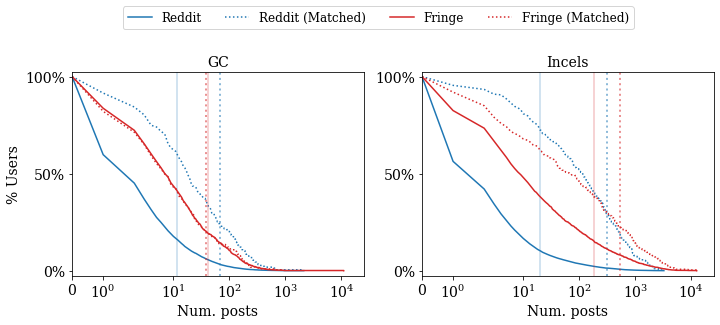

In [5]:
# User-comment CCDF
np.random.seed(437868)

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={"hspace":0.1}, sharex=True, sharey=False)
print("TD")
match_plot_ccdf(df_gb_td, df_before_after_td, axs[0], 
           colors=["tab:blue", "tab:red"])
print("----")

print("Incels")
match_plot_ccdf(df_gb_in, df_before_after_in, axs[1], 
           colors=["tab:blue", "tab:red"])


axs[0].legend(loc="upper center", bbox_to_anchor=(1.05, 1.35), ncol=4)

axs[0].set_title("GC")
axs[1].set_title("Incels")

axs[0].set_ylabel("% Users")
axs[0].set_xlabel("Num. posts")
axs[1].set_xlabel("Num. posts")

for ax in axs:
    ax.set_xscale("symlog")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([0, 2.5*10**4])
    ax.set_yticks([0, 0.5, 1])

set_size(fig, (10, 4.5))
fig.savefig(DATA_PATH + "images/matched_summary_comments.pdf", bbox_inches="tight")

# Figure 5

Mean TD: -1.0599340375911595 Mean IN: -0.5086134553987449
Low TD: -1.4345515821453783 Low IN: -0.9426261436805403
Up TD: -0.6853164930369406 Low IN: -0.07460076711694952
Mean TD: 1.2421783481100657 Mean IN: 2.051487200977384
Low TD: 0.6459663739257759 Low IN: 1.1254843458757429
Up TD: 1.8383903222943554 Low IN: 2.977490056079025
Mean TD: -0.3081163024001175 Mean IN: -0.7859833598877478
Low TD: -0.9289069001665193 Low IN: -1.5741673918139476
Up TD: 0.3126742953662844 Low IN: 0.0022006720384520895
Mean TD: -1.9261869207354623 Mean IN: -1.3560067534727536
Low TD: -2.5445973992087145 Low IN: -2.063976043318681
Up TD: -1.30777644226221 Low IN: -0.6480374636268261
Mean TD: -3.1475036040856046 Mean IN: -1.9595726203585704
Low TD: -3.761567918284015 Low IN: -2.6969815462879163
Up TD: -2.5334392898871942 Low IN: -1.2221636944292245


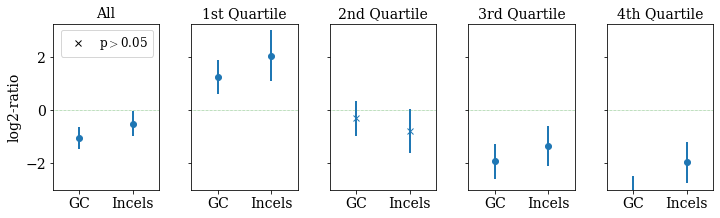

In [6]:
# log-ratio before vs after

fig, axs = plt.subplots(1, 5, figsize=(10, 3), sharey=True, sharex=True, gridspec_kw={"wspace":0.3})
flierprops = dict(marker='o', markeredgecolor='gray', markersize=3,  alpha=0.4, zorder=0)

# Calculates log-ratios in user activity
df_before_after_in["diff"] = np.log2((df_before_after_in["num_posts_y"])/df_before_after_in["num_posts_x"])
df_before_after_td["diff"] = np.log2((df_before_after_td["num_posts_y"])/df_before_after_td["num_posts_x"])

login = df_before_after_in["diff"].values
logtd = df_before_after_td["diff"].values

ax = axs[0]
ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
ax.scatter([-0.5, 0.5], [np.mean(logtd), np.mean(login)], color="tab:blue", marker="o", lw=1, zorder=1)
ax.plot([-0.5, -0.5], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], lw=2, color="tab:blue")
ax.plot([0.5, 0.5], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], lw=2, color="tab:blue")
ax.set_title("All")
ax.set_xlim([-1, 1])
ax.set_ylim([-3, 3.25])
ax.set_xticks([-0.5, 0.5])
ax.set_xticklabels(["TD", "Incels"])
titles = ["1st", "2nd", "3rd", "4th"]
# prints means!
print("Mean TD:", np.mean(logtd), "Mean IN:", np.mean(login))
print("Low TD:", np.mean(logtd) - 1.96 * sem(logtd), "Low IN:", np.mean(login) - 1.96 * sem(login))
print("Up TD:", np.mean(logtd) + 1.96 * sem(logtd), "Low IN:", np.mean(login) + 1.96 * sem(login))

for ptile in [1,2,3,4]:
    ax = axs[ptile]
    login = df_before_after_in.loc[df_before_after_in.ptile == ptile, "diff"].values
    logtd = df_before_after_td.loc[df_before_after_td.ptile == ptile, "diff"].values
    
    # prints means!
    print("Mean TD:", np.mean(logtd), "Mean IN:", np.mean(login))
    print("Low TD:", np.mean(logtd) - 1.96 * sem(logtd), "Low IN:", np.mean(login) - 1.96 * sem(login))
    print("Up TD:", np.mean(logtd) + 1.96 * sem(logtd), "Low IN:", np.mean(login) + 1.96 * sem(login))
    
    # plots "stuff"
    condx = np.mean(logtd) - 1.96 * sem(logtd) < 0 and np.mean(logtd) + 1.96 * sem(logtd) > 0
    ax.scatter([-0.5], [np.mean(logtd)], color="tab:blue", marker="x" if condx else "o" , lw=1, zorder=1)
    condx = np.mean(login) - 1.96 * sem(login) < 0 and np.mean(login) + 1.96 * sem(login) > 0
    ax.scatter([0.5], [np.mean(login)], color="tab:blue", marker="x" if condx else "o" , lw=1, zorder=1)
    ax.plot([-0.5, -0.5], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], lw=2, color="tab:blue")
    ax.plot([0.5, 0.5], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], lw=2, color="tab:blue")
    ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
    
    # y-ticks/lim and x-ticks are hardcoded
    ax.set_xticks([-0.5, 0.5]) 
    ax.set_xticklabels(["GC", "Incels"])
    ax.set_ylim([-3, 3.25])
    ax.set_xlim([-1, 1])
    ax.set_title("{} Quartile".format(titles[ptile-1]))
        
# set only one y-label
axs[0].set_ylabel('log2-ratio')

# Plots the legend
legend_elements = [Line2D([0], [0], color='black', marker='x', lw=0)]
axs[0].legend(legend_elements, ["p$>$0.05"])

set_size(fig, (10, 3))
fig.savefig(DATA_PATH +  "images/matched_comp.pdf", bbox_inches="tight")

In [7]:
# df_before_after_td.columns[-1]

# print(df_before_after_td['diff_fixation_dict'].unique())

In [8]:
# df_before_after_td[df_before_after_td['SEVERE_TOXICITY80p_x'] == 0.0]

In [9]:
# df_before_after_td_f

In [10]:
df_before_after_in_f.columns

Index(['num_posts_x', 'SEVERE_TOXICITY80p_x', 'fixation_dict_incels_x',
       'fixation_dict_td_x', 'NegativeEmotion_x', 'CoreHostility_x', 'We_x',
       'They_x', 'length_x', 'count_repeated_x', 'num_posts_y',
       'SEVERE_TOXICITY80p_y', 'fixation_dict_incels_y', 'fixation_dict_td_y',
       'NegativeEmotion_y', 'CoreHostility_y', 'We_y', 'They_y', 'length_y',
       'count_repeated_y', 'ptile'],
      dtype='object')

## Figure 7

fixation_dict in 219
fixation_dict in 219
fixation_dict gc 126
fixation_dict gc 126
user-level gc fixation_dict 0.38824386124877963
user-level in fixation_dict -0.14147334925116786
SEVERE_TOXICITY80p in 129
SEVERE_TOXICITY80p in 129
SEVERE_TOXICITY80p gc 2
SEVERE_TOXICITY80p gc 2
user-level gc SEVERE_TOXICITY80p -1.1151201415795664
user-level in SEVERE_TOXICITY80p 0.13914871654172611
NegativeEmotion in 193
NegativeEmotion in 193
NegativeEmotion gc 111
NegativeEmotion gc 111
user-level gc NegativeEmotion 0.11908019327545291
user-level in NegativeEmotion -0.019226779256715662
CoreHostility in 238
CoreHostility in 238
CoreHostility gc 165
CoreHostility gc 165
user-level gc CoreHostility -0.04739944500179332
user-level in CoreHostility 0.14330690084142192
We in 182
We in 182
We gc 119
We gc 119
user-level gc We 0.1723480008204053
user-level in We -0.045093014024476054
They in 198
They in 198
They gc 154
They gc 154
user-level gc They -0.011755213737204057
user-level in They -0.006058608570

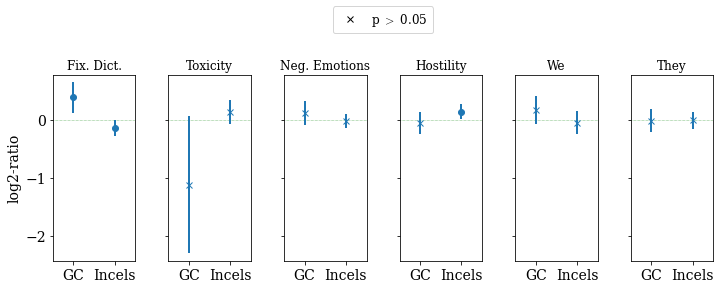

In [11]:
for x in ["SEVERE_TOXICITY80p", "NegativeEmotion", "CoreHostility", "We", 
          "They", "length", "fixation_dict"]:
    if x == "fixation_dict":
        x = "fixation_dict_gc"
    df_before_after_td["diff_" + x.replace("_gc", "")] = np.log2(df_before_after_td[x + "_y"].values/
                                                                  df_before_after_td[x + "_x"].values)
    df_before_after_td_f["diff_" + x.replace("_gc", "")] = np.log2(df_before_after_td_f[x + "_y"].values/
                                                                    df_before_after_td_f[x + "_x"].values)
    if x == "fixation_dict_gc":
        x = "fixation_dict_incels"
    df_before_after_in["diff_" + x.replace("_incels", "")] = np.log2(df_before_after_in[x + "_y"].values/
                                                                     df_before_after_in[x + "_x"].values)
    df_before_after_in_f["diff_" + x.replace("_incels", "")] = np.log2(df_before_after_in_f[x + "_y"].values/
                                                                       df_before_after_in_f[x + "_x"].values)

ylabels = [
    "Fix. Dict.",
    "Toxicity", 
    "Neg. Emotions", 
    "Hostility",
    "We",
    "They"]

fig, axs = plt.subplots(1, 6, figsize=(10, 4), sharey=True, sharex=True, gridspec_kw={"wspace":0.4})
flierprops = dict(marker='o', markeredgecolor='gray', markersize=3,  alpha=0.4, zorder=0)
from scipy.stats import sem

for idx, vx in enumerate( ["fixation_dict", "SEVERE_TOXICITY80p", "NegativeEmotion", "CoreHostility", 
                           "We", "They"]):
        
    idy = 0

    login = df_before_after_in_f  if idx <=2 and idx != 0 else df_before_after_in
    login = login
    addv = "_incels" if  vx == "fixation_dict" else ""
    login = login[(login[vx + addv +  "_x"] > 0) & (login[vx + addv +  "_y"] > 0)]
    login = login.loc[:, "diff_" + vx]
    login = login.replace([np.inf, -np.inf], np.nan)
    print(vx, "in", len(login))
    login = login[~login.isna()]
    print(vx, "in", len(login))

    logtd = df_before_after_td_f if idx <=2 and idx != 0 else df_before_after_td
    logtd = logtd
    addv = "_gc" if  vx == "fixation_dict" else ""
    logtd = logtd[(logtd[vx + addv +  "_x"] > 0) & (logtd[vx + addv +  "_y"] > 0)]
    logtd = logtd.loc[:, "diff_" + vx]
    logtd = logtd.replace([np.inf, -np.inf], np.nan)
    print(vx, "gc", len(logtd))

    logtd = logtd[~logtd.isna()]
    print(vx, "gc", len(logtd))

    ax = axs[idx]
    ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
    condx = np.mean(logtd) - 1.96 * sem(logtd) < 0 and np.mean(logtd) + 1.96 * sem(logtd) > 0
    ax.scatter([idy], [np.mean(logtd)], color="tab:blue", 
               marker="x" if condx else "o", lw=1, zorder=1)
    ax.plot([idy, idy], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], 
            lw=2, color="tab:blue", zorder=3)
    ax.set_title(ylabels[idx], size=12)#
    
    idy = 1


    condx = np.mean(login) - 1.96 * sem(login) < 0 and np.mean(login) + 1.96 * sem(login) > 0
    ax.scatter([idy], [np.mean(login)],color="tab:blue", 
               marker="x" if condx else "o", lw=1, zorder=1)
    ax.plot([idy, idy], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], 
            lw=2, color="tab:blue")
    print("user-level", "gc", vx,  np.mean(logtd))
    print("user-level", "in", vx,  np.mean(login))

            
for ax in axs.flatten():
    bottom, top = ax.get_ylim()
    v = max(abs(bottom), abs(top))
#     ax.set_ylim([-1.05 * v, 1.05 * v])
    ax.set_xticklabels(["GC", "Incels"], rotation=0, ha="center")
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.5, 1.5])

legend_elements = [Line2D([0], [0], color='black', marker='x', lw=0)]
axs[0].set_ylabel('log2-ratio')

axs[2].legend(legend_elements, [ "p $>$ 0.05"], 
                  bbox_to_anchor=(1.2, 1.4), ncol=3, loc="upper center")

set_size(fig, (10, 4))

fig.savefig(DATA_PATH + "images/matched_comp_cont.pdf", bbox_inches="tight")

---